---
title: "Application of R for Finance: Course Project"
author:  Ruihan Niu
  
date: "November 23, 2025"
format: 
  pdf:
    listings-options:
      breaklines: true
---


\newpage

# Contents

\tableofcontents

\listoftables

\listoffigures

\newpage

In [5]:

library(data.table)    # 用于大数据处理
library(dplyr)         # 数据操作
library(ggplot2)       # 数据可视化
library(lubridate)     # 日期处理
library(tseries)       # 时间序列分析
library(knitr)         # 报告生成
source("rfun.R")

# Data analysis of Pfizer (PFE) Stock Data

## Data preparation and cleaning
Firstly, I cleaned the data, adjusted the format of date and displayed the head of the data.

In [ ]:
data <-  fread("hw3data.csv")
pfe <- data %>%
  filter(tic == "PFE") %>%
  select(datadate, tic, prccd, prchd, prcld, prcod, cshtrd) %>%
  mutate(
    datadate = as.Date(datadate, format = "%d/%m/%Y")
  ) %>%
  arrange(datadate)  

head(pfe)

datadate,tic,prccd,prchd,prcld,prcod,cshtrd
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-02,PFE,18.79,18.99,18.70,18.79,39364770
2010-01-03,PFE,17.75,17.86,17.58,17.61,45551540
2010-01-04,PFE,17.08,17.28,16.99,17.21,69022590
2010-01-06,PFE,14.99,15.42,14.96,15.16,56850430
2010-01-07,PFE,14.23,14.33,14.00,14.29,67865000
2010-01-09,PFE,16.28,16.37,16.07,16.13,45369590


## Autocorrelation function 
Calculate simple daily returns and plot the autocorrelation function of them.

datadate,tic,prccd,prchd,prcld,prcod,cshtrd,simple_return
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010-01-03,PFE,17.75,17.86,17.58,17.61,45551540,-0.05534859
2010-01-04,PFE,17.08,17.28,16.99,17.21,69022590,-0.03774648
2010-01-06,PFE,14.99,15.42,14.96,15.16,56850430,-0.12236534
2010-01-07,PFE,14.23,14.33,14.00,14.29,67865000,-0.05070047
2010-01-09,PFE,16.28,16.37,16.07,16.13,45369590,0.14406184
2010-01-10,PFE,17.18,17.29,17.11,17.25,35520450,0.05528256


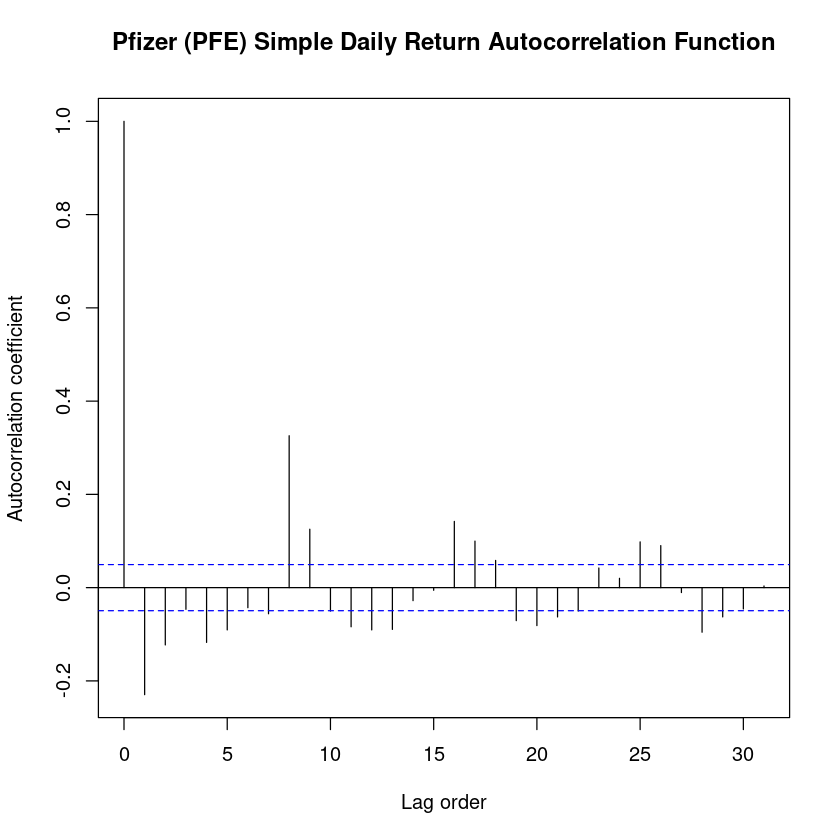

In [20]:
analysis_cols <- pfe %>%
  mutate(
    simple_return = (prccd - lag(prccd)) / lag(prccd)
  ) %>%
  na.omit()

head(analysis_cols)

# Plot the autocorrelation function
acf(analysis_cols$simple_return, 
    main = "Pfizer (PFE) Simple Daily Return Autocorrelation Function",
    xlab = "Lag order", 
    ylab = "Autocorrelation coefficient")


I converted the data to a weekly frequency and calculate the weekly average return. Check for statistically significant autocorrelation with an absolute value greater than 0.2. I find that lag 1, lag 5 and lag 6 have statistically significant autocorrelations.

week,weekly_mean_return
<date>,<dbl>
2010-01-03,-0.024419807
2010-01-10,0.009588489
2010-01-31,-0.023203462
2010-02-07,0.020986537
2010-02-28,-0.019263251
2010-03-07,0.024810420


Find absolute value greater than 0.2：
Lag order 1: Autocorrelation function = -0.341
Lag order 5: Autocorrelation function = 0.241
Lag order 6: Autocorrelation function = -0.223


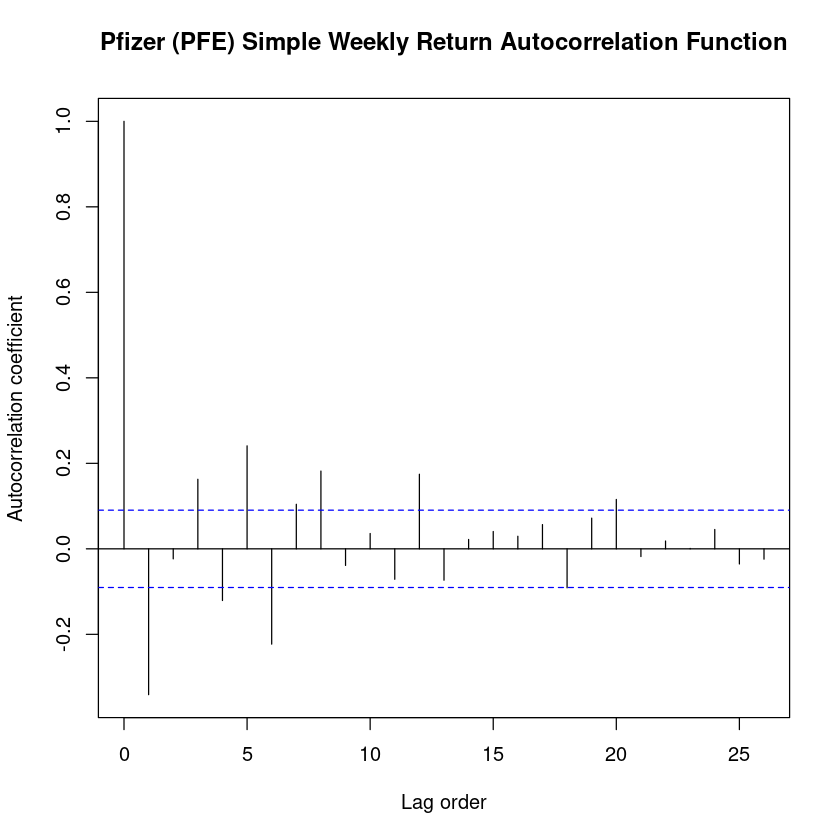

In [ ]:
# Convert the data to a weekly frequency and calculate the weekly average return.
weekly_returns <- analysis_cols %>%
  mutate(week = floor_date(datadate, "week")) %>%  # 按周分组
  group_by(week) %>%
  summarize(
    weekly_mean_return = mean(simple_return, na.rm = TRUE)
  ) %>%
  ungroup() %>%
  na.omit()

head(weekly_returns)

acf(weekly_returns$weekly_mean_return,
    main = "Pfizer (PFE) Simple Weekly Return Autocorrelation Function",
    xlab = "Lag order", 
    ylab = "Autocorrelation coefficient")

# Check for statistically significant autocorrelation with an absolute value greater than 0.2.
acf_result <- acf(weekly_returns$weekly_mean_return, plot = FALSE)


acf_values <- acf_result$acf
significant_lags <- which(abs(acf_values) > 0.2 & 
                           seq_along(acf_values) > 1)  

if (length(significant_lags) > 0) {
  cat("Find absolute value greater than 0.2：\n")
  for (lag in significant_lags) {
    cat(sprintf("Lag order %d: Autocorrelation function = %.3f\n", 
                lag - 1, acf_values[lag]))
  }
} else {
  cat("Not find absolute value greater than 0.2\n")
}

# Moving Average Crossover Strategy
I selected data after January 1,2020 to implement the moving average crossover strategy. Custom functions to generate buy and sell signals and backtest strategy were created in a .R script.

In [27]:
pfe_2020 <- pfe %>%
  filter(datadate >= "2020-01-01")
head(pfe_2020)

datadate,tic,prccd,prchd,prcld,prcod,cshtrd
<date>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2020-01-04,PFE,31.75,32.2800,31.5300,31.92,25337030
2020-01-05,PFE,37.64,37.9397,37.3850,37.85,21498360
2020-01-06,PFE,35.46,35.7300,34.9100,35.50,72934500
2020-01-07,PFE,33.74,34.5400,33.7200,34.54,69459630
2020-01-09,PFE,36.88,37.8200,36.5100,37.79,34287750
2020-01-10,PFE,36.37,37.0900,36.1628,36.91,21355360


I generated signals, backtested the strategy and plotting the performance summary in the following cells.